Now analysis of parsed data from part 1.

Useful ref http://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

http://stackoverflow.com/questions/21828398/what-is-the-difference-between-pandas-agg-and-apply-function

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import wilcoxon, friedmanchisquare, jarque_bera  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pwd

'C:\\Users\\RCole02.ROYALSURREY\\Desktop\\GitHub\\Useful-python-for-medical-physics\\Experiments in ipython notebooks\\Project\\Lung comparison'

## Helper functions

In [3]:
def query_data(Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff
    temp = d[Col][(d['structure'] == structure) & (d['metric'] == metric)]
    return temp

In [4]:
def my_wilcox(data):                    # helper function to return p-value, pass difference data as series from dataframe
    z_stat, p_val = wilcoxon(data)   # if only 1 value passed
    #z_stat, p_val = wilcoxon(data.as_matrix())   # if only 1 value passed
    return p_val

In [5]:
my_wilcox([1,2,3,4,6,7,2,352,3])

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


0.0075792819433897285

In [6]:
def my_jarque_bera(data):
    jb_value, pvalue = jarque_bera(data)
    if pvalue > 0.05:
        print('Likely normal.')
    else:
        print('Likely not normal.')
    return pvalue

Likely normal.


0.84648172489061413

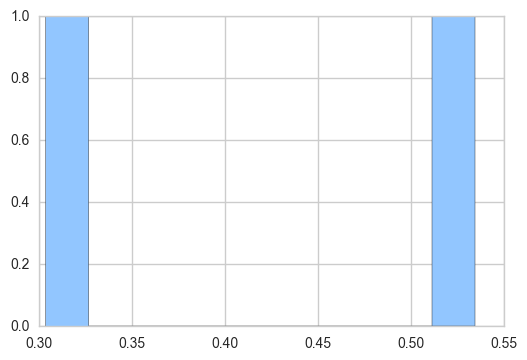

In [7]:
normal = np.random.normal(loc=0.0, scale=1.0, size=2)
# random = np.random.rand(10000)
plt.hist(normal)
my_jarque_bera(normal)

In [8]:
def my_friedman(data1, data2, data3):    # requires at least 3 args
    statistic, pvalue =  friedmanchisquare(data1, data2, data3)
    return pvalue

In [9]:
my_friedman([1,2,3,4,5], [6,7,8,9,10], [6,7,8,9,13])

0.0086516952031205907

In [10]:
def normal_hist_plot(data, title, *args, **kwargs):
    p_val = my_jarque_bera(np.asarray(data))
    data.hist()
    plt.ylabel('Frequency')
    plt.xlabel('Dose (Gy)')
    plt.title(title + ' : normality of data p = ' + str(np.round(p_val, decimals = 3)))
    plt.savefig('Shapiro.png')

In [49]:
def bland_altman_plot(Dm_data, AAA_data, structure, metric, *args, **kwargs):
    Dm_data     = np.asarray(Dm_data)
    AAA_data     = np.asarray(AAA_data)
    z_stat, p_val = wilcoxon(Dm_data, AAA_data)
    mean      = np.mean([Dm_data, AAA_data], axis=0)
    diff      = Dm_data - AAA_data                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    # plt.scatter(mean, diff, *args, **kwargs)
    plt.scatter(AAA_data, diff, *args, **kwargs)
    plt.axhline(md,           color='red', linestyle='-')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.xlabel('AAA Dose (Gy)')
    plt.ylabel('Dm - AAA Difference (Gy)')
    plt.title( str(np.round(md, decimals = 3)) + ' Gy difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    plt.savefig('BA.png')

## Import and clean data 

In [12]:
d = pd.read_csv('data/AAA_Dm_data_30_9.csv')

Drop entries with no values, and calculate percent difference

In [13]:
d = d[d.AAA != 0]    # drop zero rows

In [14]:
#d = d[d.structure != 'L Brachial plex']   # drop these
#d = d[d.structure != 'Both Lungs']
#d = d[d.metric != 'V20GY']
#d = d[d.metric != 'V30GY']
#d = d[d.metric != 'V40GY']
#d = d[d.metric != 'V50GY']
#d = d[d.metric != 'V55GY']
#d = d[d.metric != 'DRX']

In [15]:
d['Dm-AAA'] = d.Dm - d.AAA  # create absolute difference col, not %

In [16]:
d.head()

,Case,structure,metric,AAA,Dm,Dm-AAA
0,Case1,BODY,D2%,25.853042,25.685894,-0.167149
1,Case1,BODY,D5%,14.523130,14.388797,-0.134333
2,Case1,BODY,D50%,0.430243,0.399853,-0.030390
3,Case1,BODY,D95%,0.047550,0.065952,0.018402
4,Case1,BODY,D99%,0.009510,0.022860,0.013350


In [17]:
d.loc[d['Dm-AAA'].idxmax()] # Some large differences for Brachial plex, INVESTIGATE

Case                  Case31
structure    R Brachial plex
metric                   DHI
AAA                  44.7183
Dm                   781.014
Dm-AAA               736.296
Name: 4978, dtype: object

In [18]:
d.metric.unique()

array(['D2%', 'D5%', 'D50%', 'D95%', 'D99%', 'D1CC', 'D0.1CC', 'DMAX',
       'DSD', 'DRX', 'DHI', 'V5GY', 'V12.5GY', 'V20GY', 'V30GY', 'V40GY',
       'V50GY', 'V55GY'], dtype=object)

In [19]:
len(d.Case.unique())

15

In [20]:
d.structure.unique()

array(['BODY', 'GTV', 'Heart', 'Foramen', 'Foramen+3mm', 'Oesophagus',
       'Trachea', 'Bronchial tree', 'L Brachial plex', 'R Brachial plex',
       'Airway avoidance', 'PTV CHEST', 'Lt_Lung', 'PTV ring 2-3cm',
       'Rt_Lung', 'Both Lungs-ITV', 'Skin', 'Ribs', 'Skin-PTV+2cm', 'ITV',
       'Ribs-PTV', 'Inner Ring', 'Body', 'Both Lungs', 'Great vessels',
       'Liver'], dtype=object)

# Check against constraints

In [21]:
constraints = pd.read_csv('data/SABR_lung_constraints.csv')
constraints = constraints.drop('3_Fraction_54Gy', 1)   # drop 54 Gy

In [22]:
# constraints[(constraints['Structure'] == 'PTV CHEST') & (constraints['Metric'] == 'D95%')]
constraints = constraints[constraints['metric'].isin(d.metric.unique())]   # get only constraints where we have exported metrics
constraints

,structure,metric,Sign,5_Fraction_55Gy,Unit,Of_Prescription_dose?
0,PTV CHEST,D95%,>,100,%,1
1,PTV CHEST,D99%,>,90,%,1
2,PTV CHEST,D0.1CC,between,118-134,%,1
3,Foramen,DMAX,<,25,Gy,0
4,Oesophagus,D0.1CC,<,27,Gy,0
5,R Brachial plex,D0.1CC,<,27,Gy,0
6,L Brachial plex,D0.1CC,<,27,Gy,0
7,Heart,D0.1CC,<,27,Gy,0
8,Trachea,D0.1CC,<,32,Gy,0
9,Bronchial tree,D0.1CC,<,32,Gy,0


In [23]:
PTV_D95_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D95%') & (d['AAA'] > 55.0) & (d['Dm'] < 55.0)]
#print(wilcoxon(test_df['diff'])) 
PTV_D95_fail

,Case,structure,metric,AAA,Dm,Dm-AAA
489,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683
4287,Case30,PTV CHEST,D95%,56.172306,51.618767,-4.553539


In [24]:
PTV_D99_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D99%') & (d['AAA'] > 0.9*55.0) & (d['Dm'] < 0.9*55.0)]
PTV_D99_fail  

,Case,structure,metric,AAA,Dm,Dm-AAA


In [25]:
PTV_D01CC_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D0.1CC') & (((d['AAA'] > 1.18*55) & (d['Dm'] < 1.18*55)) | ((d['AAA'] < 1.34*55) & (d['Dm'] > 1.34*55)))]
print(1.18*55)
print(1.34*55)
PTV_D01CC_fail

64.89999999999999
73.7


,Case,structure,metric,AAA,Dm,Dm-AAA
4740,Case31,PTV CHEST,D0.1CC,72.846993,74.024337,1.177344


In [26]:
Foramen_D01CC_fail = d[(d['structure'] == 'Foramen') & (d['metric'] == 'DMAX') & (d['AAA'] < 25.0) & (d['Dm'] > 25.0)]
Foramen_D01CC_fail  

,Case,structure,metric,AAA,Dm,Dm-AAA


In [27]:
Oesophagus_D01CC_fail = d[(d['structure'] == 'Oesophagus') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
Oesophagus_D01CC_fail  

,Case,structure,metric,AAA,Dm,Dm-AAA


In [28]:
LBrachial_D01CC_fail = d[(d['structure'] == 'L Brachial plex') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
LBrachial_D01CC_fail  

,Case,structure,metric,AAA,Dm,Dm-AAA
1122,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653
3912,Case25,L Brachial plex,D0.1CC,0.054618,63.428739,63.374121
4650,Case31,L Brachial plex,D0.1CC,0.109680,77.576481,77.466802


In [29]:
RBrachial_D01CC_fail = d[(d['structure'] == 'R Brachial plex') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
RBrachial_D01CC_fail  

,Case,structure,metric,AAA,Dm,Dm-AAA
222,Case1,R Brachial plex,D0.1CC,0.324991,65.801627,65.476636
2814,Case17,R Brachial plex,D0.1CC,0.435957,48.809596,48.373640


In [30]:
Heart_D01CC_fail = d[(d['structure'] == 'Heart') & (d['metric'] == 'D0.1CC')& (d['Dm'] > 27.0) & (d['AAA'] < 27.0)]
Heart_D01CC_fail 

,Case,structure,metric,AAA,Dm,Dm-AAA


In [31]:
Trachea_D01CC_fail = d[(d['structure'] == 'Trachea') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 32.0) & (d['Dm'] > 32.0)]
Trachea_D01CC_fail  

,Case,structure,metric,AAA,Dm,Dm-AAA
3966,Case25,Trachea,D0.1CC,15.948424,69.349889,53.401465


In [32]:
Bronchial_D01CC_fail = d[(d['structure'] == 'Bronchial tree') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 32.0) & (d['Dm'] > 32.0)]
Bronchial_D01CC_fail 

,Case,structure,metric,AAA,Dm,Dm-AAA


In [33]:
Ribs_D01CC_fail = d[(d['structure'] == 'Ribs') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 35.0) & (d['Dm'] > 35.0)]
Ribs_D01CC_fail 

,Case,structure,metric,AAA,Dm,Dm-AAA


In [34]:
Ribs_V30_fail = d[(d['structure'] == 'Ribs') & (d['metric'] == 'V30GY') & (d['AAA'] < 30.0) & (d['Dm'] > 30.0)]
Ribs_V30_fail 

,Case,structure,metric,AAA,Dm,Dm-AAA


In [35]:
Lungs_V20_fail = d[(d['structure'] == 'Both Lungs-ITV') & (d['metric'] == 'V20GY') & (d['AAA'] < 10.0) & (d['Dm'] > 10.0)]
Lungs_V20_fail 

,Case,structure,metric,AAA,Dm,Dm-AAA


In [36]:
Lungs_V125_fail = d[(d['structure'] == 'Both Lungs-ITV') & (d['metric'] == 'V12.5GY') & (d['AAA'] < 15.0) & (d['Dm'] > 15.0)]
Lungs_V125_fail 

,Case,structure,metric,AAA,Dm,Dm-AAA


In [37]:
Lungs_V5_fail = d[(d['structure'] == 'Both Lungs-ITV') & (d['metric'] == 'V5GY') & (d['AAA'] < 26.0) & (d['Dm'] > 26.0)]
Lungs_V5_fail 

,Case,structure,metric,AAA,Dm,Dm-AAA


In [38]:
Liver_D50_fail = d[(d['structure'] == 'Liver') & (d['metric'] == 'D50%') ]
Liver_D50_fail   

,Case,structure,metric,AAA,Dm,Dm-AAA
3458,Case22,Liver,D50%,1.250632,1.294880,0.044248
4196,Case25,Liver,D50%,6.847959,6.713133,-0.134825


Need to export Lungs-ITV D1500CC, D1000CC, Liver 700CC, V21, V15, DMEAN

Investigate these failures.

In [39]:
failures = PTV_D95_fail
failures = failures.append(PTV_D01CC_fail)
failures = failures.append(Trachea_D01CC_fail)
failures = failures.append(Liver_D50_fail)
failures = failures.append(LBrachial_D01CC_fail)
failures = failures.append(RBrachial_D01CC_fail)

print(failures.Case.unique().size)
failures

8


,Case,structure,metric,AAA,Dm,Dm-AAA
489,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683
4287,Case30,PTV CHEST,D95%,56.172306,51.618767,-4.553539
4740,Case31,PTV CHEST,D0.1CC,72.846993,74.024337,1.177344
3966,Case25,Trachea,D0.1CC,15.948424,69.349889,53.401465
3458,Case22,Liver,D50%,1.250632,1.294880,0.044248
4196,Case25,Liver,D50%,6.847959,6.713133,-0.134825
1122,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653
3912,Case25,L Brachial plex,D0.1CC,0.054618,63.428739,63.374121
4650,Case31,L Brachial plex,D0.1CC,0.109680,77.576481,77.466802
222,Case1,R Brachial plex,D0.1CC,0.324991,65.801627,65.476636


# ITV D50

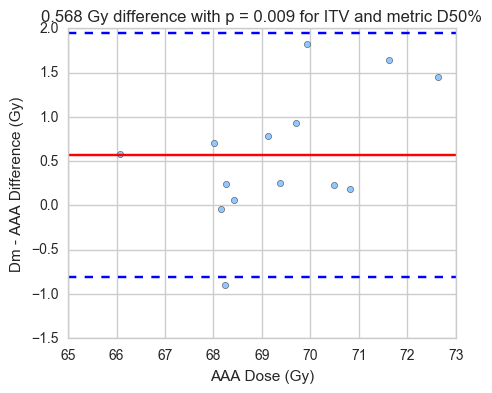

In [50]:
fig = plt.figure(figsize=(5, 4))
structure = 'ITV'
metric = 'D50%'
bland_altman_plot(query_data('Dm', structure, metric), query_data('AAA',structure, metric), structure, metric)
plt.show()

Likely normal.


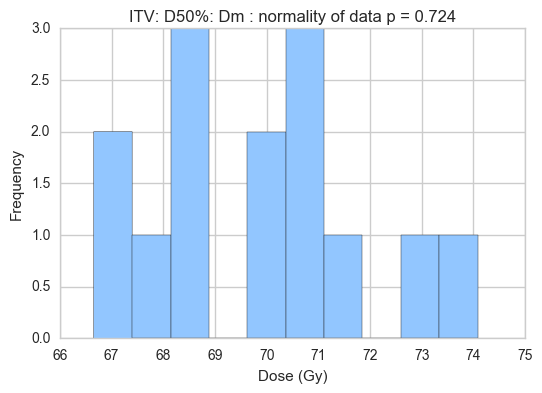

In [41]:
structure = 'ITV'
metric = 'D50%'
AAA_or_AXB = 'Dm'    # AAA or Dm
title = structure + ': ' + metric + ': ' + AAA_or_AXB
normal_hist_plot(query_data(AAA_or_AXB,structure, metric), title)

# Extract stats grouped by structure for D50% metric

In [42]:
stats = {  'Mean' : 'mean', 'Variance':'var', 'SEM':'sem', 'Counts':'count', 'Max':'max'} 

aggregations = {'Dm-AAA': stats}  # , 'AAA': stats, 'Dm': stats

res_table = d[d['metric']  == 'D50%'].groupby(['structure']).agg(aggregations)   # returns a heirachial dataframe
res_table

Dm-AAA                                       
                        Max    Variance Counts       SEM      Mean
structure                                                         
Airway avoidance   0.053335    0.001345     14  0.009802 -0.018405
BODY               0.011675    0.000248     14  0.004211 -0.003599
Body               0.001679         NaN      1       NaN  0.001679
Both Lungs         0.014224    0.000926      5  0.013606 -0.008474
Both Lungs-ITV     0.032892    0.001672     15  0.010556 -0.018235
Bronchial tree     0.128285    0.004239     15  0.016811  0.007682
Foramen            0.025543    0.006097     15  0.020161 -0.071230
Foramen+3mm        0.024562    0.009321     18  0.022756 -0.071668
GTV               -0.900259         NaN      1       NaN -0.900259
Great vessels     -0.049074         NaN      1       NaN -0.049074
Heart              0.050727    0.001397     15  0.009650 -0.006242
ITV                1.828439    0.534273     14  0.195352  0.568196
Inner Ring         0.567988    0.049546      6  0.090871  0.283500
L Brachial plex   39.023162  137.847887     14  3.137878  4.801599
Liver              0.044248    0.016034      2  0.089537 -0.045289
Lt_Lung            0.012416    0.001083     15  0.008498 -0.036095
Oesophagus         0.032761    0.008271     15  0.023482 -0.025135
PTV CHEST          1.697743    1.060251     15  0.265863  0.235042
PTV ring 2-3cm     0.763267    0.112914     15  0.086762  0.201877
R Brachial plex   18.718139   23.331538     15  1.247171  1.258501
Ribs               0.181102    0.011147     15  0.027261 -0.058496
Ribs-PTV           0.015631    0.003046     13  0.015306 -0.040976
Rt_Lung            0.006038    0.001596     15  0.010315 -0.029733
Skin              -0.002897    0.000275     14  0.004431 -0.025002
Skin-PTV+2cm       0.019201    0.000272      6  0.006728 -0.001662
Trachea            0.067776    0.000783     15  0.007223 -0.000304

# Mean difference grouped by structure and metric

In [43]:
res_table2 = d.groupby(['structure', 'metric'],as_index=False).mean()  # just get mean values 

In [44]:
mean_diff_table = res_table2.pivot(index='structure', columns='metric', values='Dm-AAA')  # pivot table for diff values
#diff_table.reset_index(level=0, inplace=True)    # must convert the index back into a column
mean_diff_table.index
# diff_table.loc['BODY']

Index(['Airway avoidance', 'BODY', 'Body', 'Both Lungs', 'Both Lungs-ITV',
       'Bronchial tree', 'Foramen', 'Foramen+3mm', 'GTV', 'Great vessels',
       'Heart', 'ITV', 'Inner Ring', 'L Brachial plex', 'Liver', 'Lt_Lung',
       'Oesophagus', 'PTV CHEST', 'PTV ring 2-3cm', 'R Brachial plex', 'Ribs',
       'Ribs-PTV', 'Rt_Lung', 'Skin', 'Skin-PTV+2cm', 'Trachea'],
      dtype='object', name='structure')

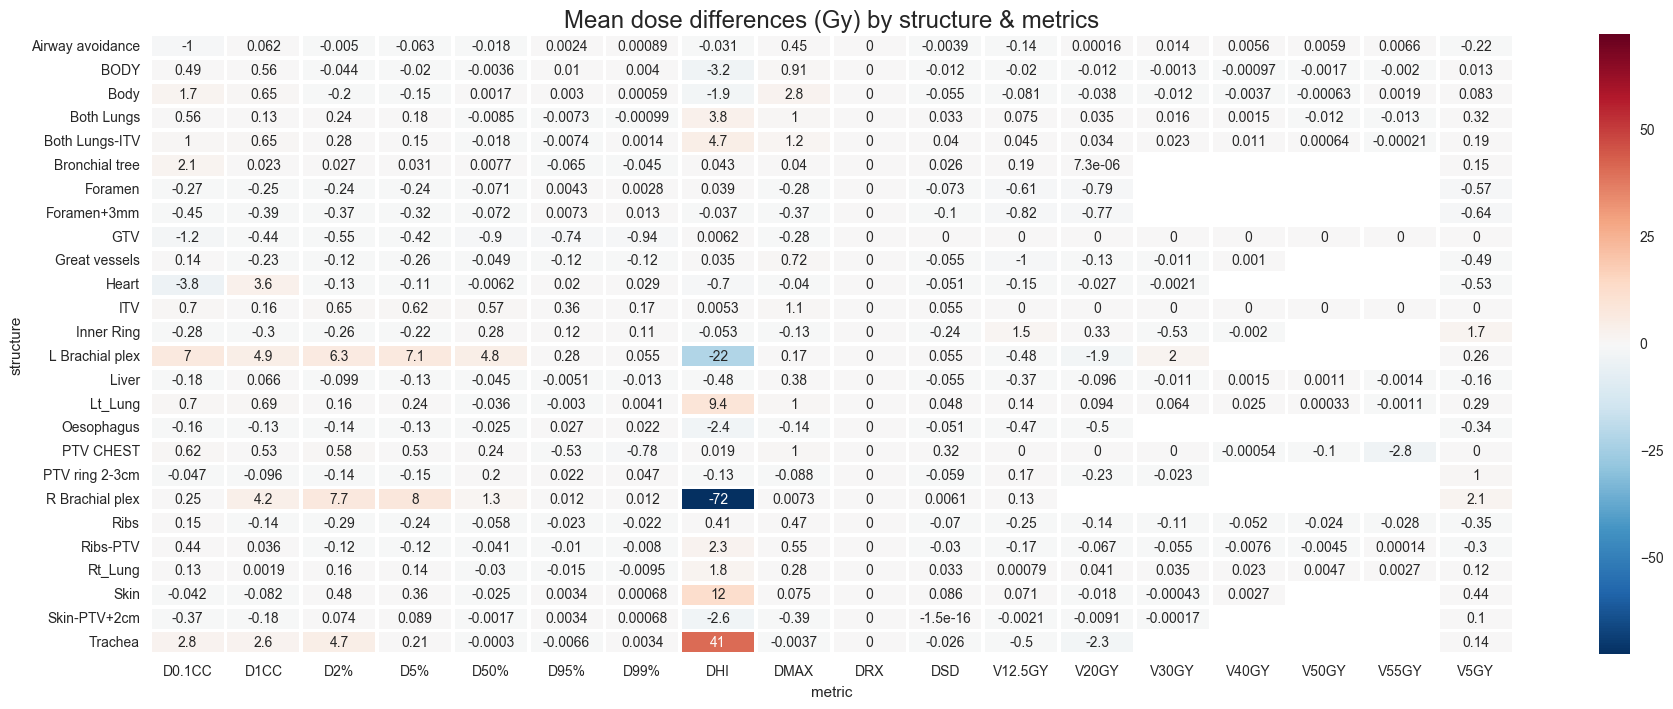

In [45]:
plt.figure(figsize=(22, 8))
ax1 = sns.heatmap(mean_diff_table, annot=True, linewidths=2.0, cbar=True)
ax1.set_title('Mean dose differences (Gy) by structure & metrics', size='xx-large');
plt.savefig('All structures and metrics mean dose difference.png', dpi=500)

In [46]:
metrics_of_interest = [ 'D95%', 'D50%', 'D99%', 'D0.1CC', 'DMAX']

structures_of_interest = constraints['structure'].unique()
structures_of_interest = np.append(structures_of_interest, ['ITV'])   # add the ITV
structures_of_interest

array(['PTV CHEST', 'Foramen', 'Oesophagus', 'R Brachial plex',
       'L Brachial plex', 'Heart', 'Trachea', 'Bronchial tree', 'Ribs',
       'ITV'], dtype=object)

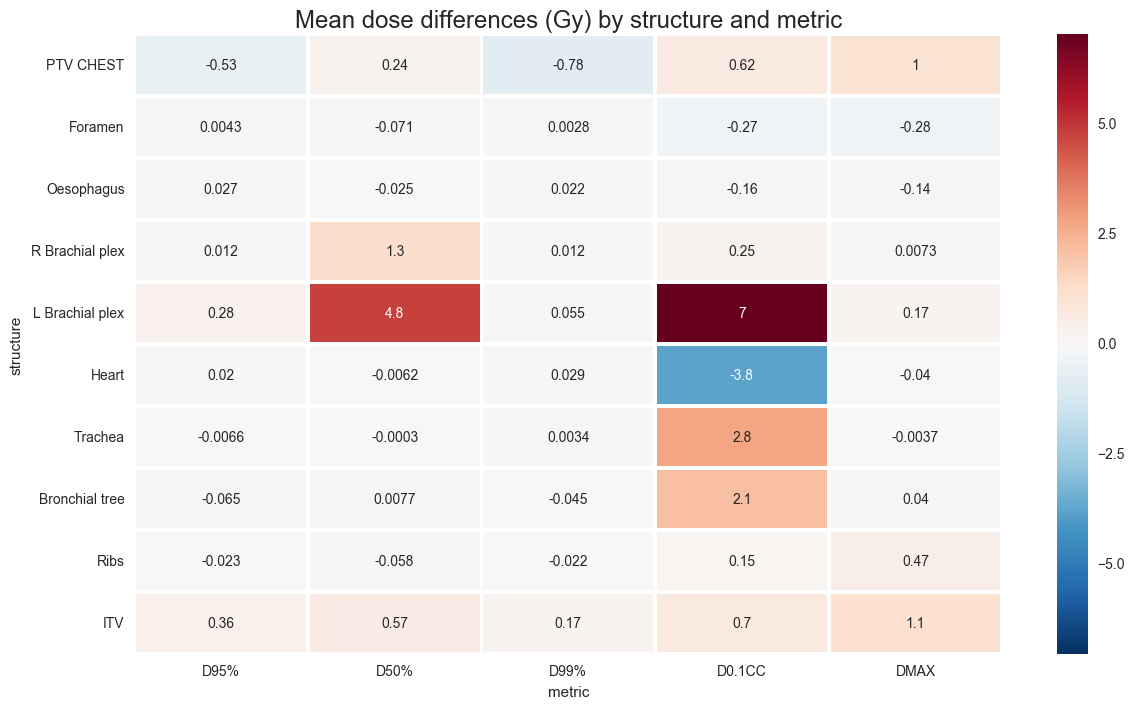

In [47]:
sub_diff_table = mean_diff_table[metrics_of_interest].loc[structures_of_interest]

plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(sub_diff_table, annot=True, linewidths=2.0, cbar=True)
ax1.set_title('Mean dose differences (Gy) by structure and metric', size='xx-large')
plt.savefig('Select structures and metrics mean dose difference.png', dpi=500)

## Get wilcoxon p value of differences 

In [48]:
i = len(structures_of_interest)
j = len(metrics_of_interest)
wilcox_data = np.zeros((i,j))  # init an empty array

In [49]:
j = 0
for structure in structures_of_interest:
    i = 0
    for metric in metrics_of_interest:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['Dm-AAA']
        wilcox_data[j][i] = my_wilcox(D.values)
        i = i + 1
    j = j+ 1  

/Users/robincole/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:2384: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Convert to dataframe

In [50]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_of_interest,    # 1st column as index
...              columns=metrics_of_interest)  # 1st row as the column names

In [51]:
wilcox_data_df

,D95%,D50%,D99%,D0.1CC,DMAX
PTV CHEST,0.191446,0.155635,0.040888,0.046826,0.005376
Foramen,0.232979,0.003772,0.211476,0.000655,0.000976
Oesophagus,0.002162,0.394246,0.012453,0.008985,0.068476
R Brachial plex,0.099540,0.139756,0.078292,0.649563,0.491119
L Brachial plex,0.064039,0.035465,0.047990,0.509797,0.440867
Heart,0.012453,0.733271,0.001206,0.532130,0.826049
Trachea,0.334277,0.909561,0.139756,0.211476,0.562351
Bronchial tree,0.019878,0.690945,0.030908,0.069144,0.665896
Ribs,0.069144,0.040888,0.023096,0.495521,0.035193
ITV,0.157811,0.009181,0.271948,0.015654,0.004276


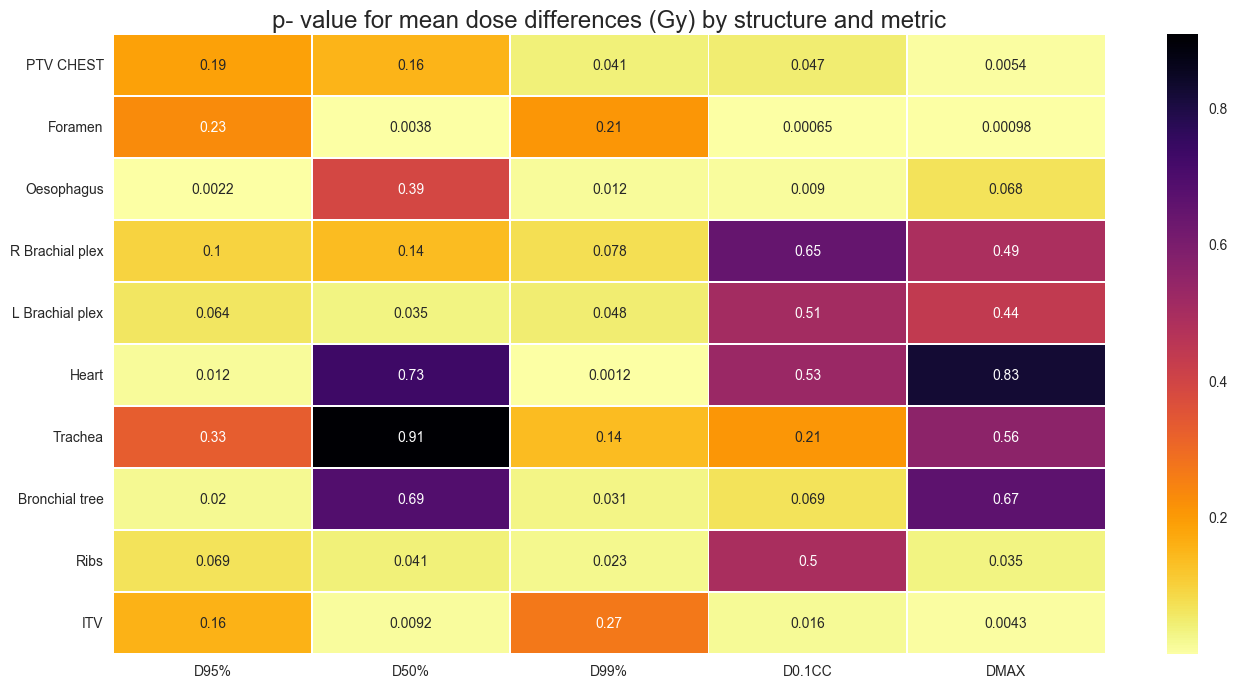

In [52]:
confidence = 1.0
plt.figure(figsize=(16, 8))
ax2 = sns.heatmap(wilcox_data_df[wilcox_data_df<confidence], annot=True, linewidths=.5,  cbar=True, cmap='inferno_r')
ax2.set_title('p- value for mean dose differences (Gy) by structure and metric', size='xx-large')
plt.savefig('p value for mean dose differences for select structure and metric.png', dpi=500)

Plot dose differences where statistically significant

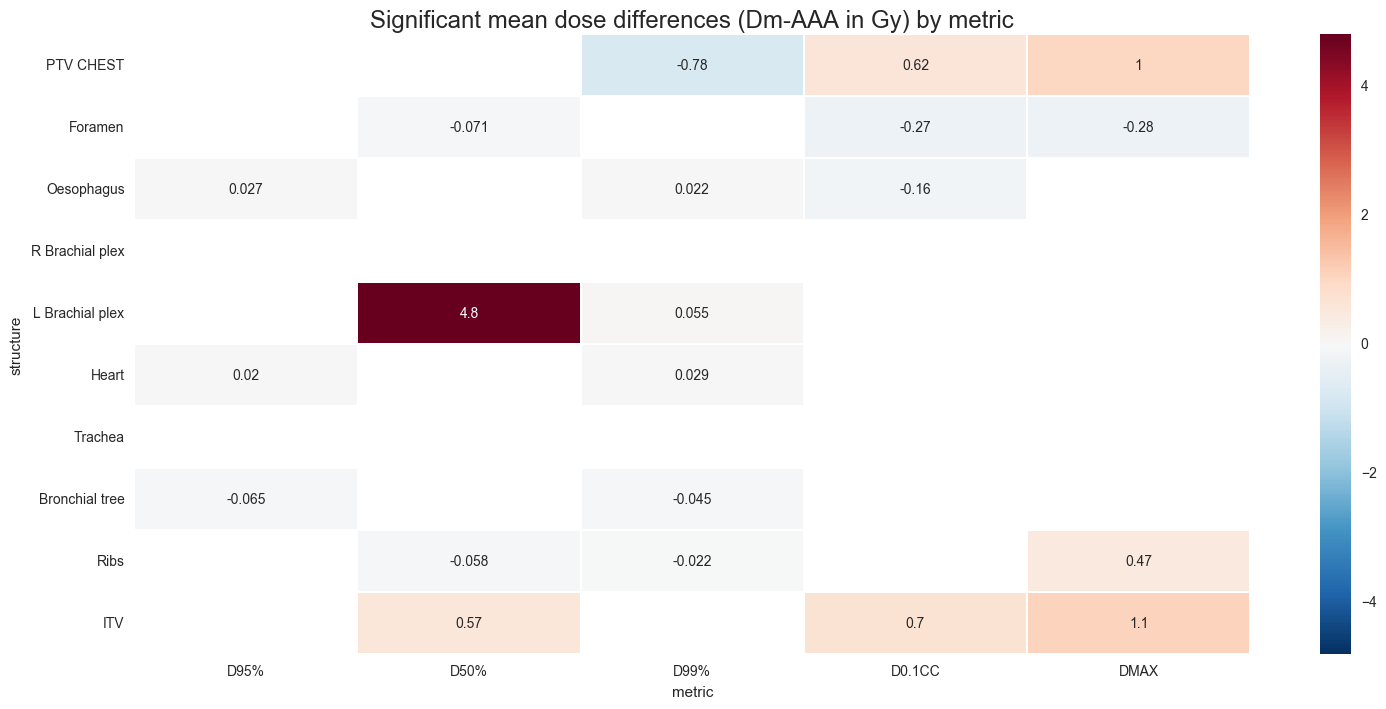

In [53]:
plt.figure(figsize=(18, 8)) 

data = sub_diff_table[wilcox_data_df<0.05]

mask = np.zeros_like(data, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True


ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0) #  mask=mask,
ax3.set_title('Significant mean dose differences (Dm-AAA in Gy) by metric', size='xx-large')
plt.savefig('p value for mean dose differences for significant select structure and metric.png', dpi=500)

Combine constraints with max, mean and signifance of dose differences, and failures

In [54]:
# constraints # constraints of interes  

In [55]:
constraints_full = constraints.copy()

In [56]:
Mean_diff = mean_diff_table.lookup(constraints['structure'].values, constraints['metric'].values)  # mean diff values from lookup                              
constraints_full['Mean_diff'] = pd.DataFrame(Mean_diff)   # convert to dataframe and apply 

In [57]:
wilcox  =  wilcox_data_df.lookup(constraints['structure'].values, constraints['metric'].values)
constraints_full['wilcox'] = pd.DataFrame(wilcox)

In [58]:
constraints_full = constraints_full.drop('Of_Prescription_dose?', 1) 

In [59]:
test1 = failures[(failures['structure'] == 'PTV CHEST') & ((failures['metric'] == 'D95%'))] # dose constraint violated
test1.size != 0   # True = there is a failure

True

In [60]:
failures

,Case,structure,metric,AAA,Dm,Dm-AAA
489,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683
4287,Case30,PTV CHEST,D95%,56.172306,51.618767,-4.553539
4740,Case31,PTV CHEST,D0.1CC,72.846993,74.024337,1.177344
3966,Case25,Trachea,D0.1CC,15.948424,69.349889,53.401465
3458,Case22,Liver,D50%,1.250632,1.294880,0.044248
4196,Case25,Liver,D50%,6.847959,6.713133,-0.134825
1122,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653
3912,Case25,L Brachial plex,D0.1CC,0.054618,63.428739,63.374121
4650,Case31,L Brachial plex,D0.1CC,0.109680,77.576481,77.466802
222,Case1,R Brachial plex,D0.1CC,0.324991,65.801627,65.476636


In [61]:
constraints_failed = pd.merge(constraints_full, failures, how='inner', on=['structure', 'metric'])
constraints_failed  # get merged dataframe with failed constraints and details of the failure

,structure,metric,Sign,5_Fraction_55Gy,Unit,Mean_diff,wilcox,Case,AAA,Dm,Dm-AAA
0,PTV CHEST,D95%,>,100,%,-0.526656,0.191446,Case5,55.648904,54.883221,-0.765683
1,PTV CHEST,D95%,>,100,%,-0.526656,0.191446,Case30,56.172306,51.618767,-4.553539
2,PTV CHEST,D0.1CC,between,118-134,%,0.619299,0.046826,Case31,72.846993,74.024337,1.177344
3,R Brachial plex,D0.1CC,<,27,Gy,0.246638,0.649563,Case1,0.324991,65.801627,65.476636
4,R Brachial plex,D0.1CC,<,27,Gy,0.246638,0.649563,Case17,0.435957,48.809596,48.373640
5,L Brachial plex,D0.1CC,<,27,Gy,7.044839,0.509797,Case12,0.108812,74.346465,74.237653
6,L Brachial plex,D0.1CC,<,27,Gy,7.044839,0.509797,Case25,0.054618,63.428739,63.374121
7,L Brachial plex,D0.1CC,<,27,Gy,7.044839,0.509797,Case31,0.109680,77.576481,77.466802
8,Trachea,D0.1CC,<,32,Gy,2.783140,0.211476,Case25,15.948424,69.349889,53.401465


In [62]:
constraints_failed.to_csv('constraints_failed.csv', index=False) 

# Testing

7.55692945586e-10
7.55692945586e-10


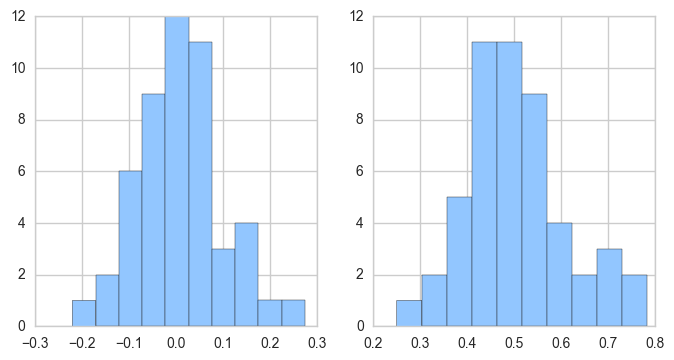

In [63]:
#Test of wilcoxon. See how size of distribution and difference in mean affect result p 

dist_diff = 0.5
samples = 50

mu, sigma = 0, 0.1 
s = np.random.normal(mu, sigma, samples)

mu2, sigma = 0+dist_diff, 0.1 
s2 = np.random.normal(mu2, sigma, samples)

fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(s)

plt.subplot(1, 2, 2)
plt.hist(s2)

z_stat, p_val = wilcoxon(s, s2)   # if only 1 value passed
print(p_val)

z_stat, p_val = wilcoxon(s-s2)   # if only 1 value passed
print(p_val)